### Using the CTA to probe dark matter in the galactic center

Dark matter annihilation can produce gamma-rays through annihilation as predicted by certain models, for example WIMP dark matter. As the dark matter particle is its own antiparticle, annihilation will occur in regions of high enough density. This annihilaiton will produce a standard model particle and anti-particle pair, for example b and bbar quarks. These particles then decay into a variety of products indlucing gamma-rays. The gamma-ray flux is thus dependent on the annihilation channel and the dark matter density. Furthermore, the flux is also dependent on the mass of the dark matter particle.

The galactic center is well suited to indirect dark matter searches with gamma rays since the high density implies a higher probability of annihilation and thus a larger signal. 

This notebook explores a preliminary method of probing this signal that can be conducted before a large amount of observations have been taken and binned in different energies. It relies on 2D spatial analysis of the distribution of dark matter induced gamma rays, as opposed to a spectral analysis which requires sufficient observations over a range of energies. 

### Updates for gammapy0.8.dev6769

This version of this notebook is compatible with Gammapy's development version 0.8.dev6769. A previous version compatible with the stable release 0.7 can be found here [here](dark_matter_galactic_center_0.7.ipynb).

Here is a list of changes between the two notebooks:
- import statements changed
- JFactory and Flux computations are changed
- target region (simplified)
- exclusion mask: func to_image() now required
- Image estimator
    - requires 3d geom
    - runs faster
    - make cutout at this stage, not later
- outputs (3 cubes instead of 6 maps) 
- background estimator
    - also in 3d geom (1 bin)
    - **** Problem: 2D exclusion mask, background estimator requires 3D ****
- sum over axes for cubes to return 2D images
    - for exposure, don't sum instead get image by coord
- cutout becomes make_cutout to show image, but cannot save cutout image
- psf kernel is computed independently as guassian 

NOTE: As gammapy continues evolving this notebook may not work anymore. If so, reference the notebook in the [gammapy-extra github](https://github.com/gammapy/gammapy-extra/tree/master/notebooks). which should be countinously updated. To install the latest development version of gammapy run this in terminal (for macOS):

    python -m pip install --user git+https://github.com/gammapy/gammapy.git

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import numpy as np
import astropy.units as u
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord, Angle
from astropy.wcs import WCS
from astropy.convolution import Gaussian2DKernel
from regions import CircleSkyRegion
from gammapy.data import DataStore
from gammapy.maps import Map, WcsMap, WcsNDMap, MapAxis, WcsGeom
from gammapy.cube import MapMaker
from gammapy.background import AdaptiveRingBackgroundEstimator
from gammapy.astro.darkmatter import (
    profiles,
    JFactory,
    PrimaryFlux,
    compute_dm_flux,
)
import gammapy

# You may see a Warning concerning XSPEC or ds9
# We will note use Xspec spectral models or ds9 for image display so these can be ignored
import sherpa.astro.ui as sh
import sherpa

failed to import sherpa.image.ds9_backend due to 
'RuntimeErr: DS9Win unusable: Could not find ds9 on your PATH'


### Gammapy Dark Matter Utilities

Some of the gammapy packages relevant to dark matter searches are explored [here](https://github.com/gammapy/gammapy-extra/blob/master/notebooks/astro_dark_matter.ipynb) (note: this link will go to the latest version of the notebook, so it may not be compatible with gammapy 0.8.dev6769). Below I will show how to make a skymap of the gamma ray flux from dark matter in order to show what kind of signal we would hope to detect in the residual map from the data. 

The gamma ray flux can be modelled as 

$$\frac{d\Phi}{dE} = \frac{\langle{\sigma}v\rangle}{8 \pi m_{DM}^2}\frac{dN_{\gamma}}{dE}{J(\Delta\Omega)}$$

where $\langle{\sigma}v\rangle$ is the cross section, $m_{DM}$ is the particle mass, $\frac{dN_{\gamma}}{dE}$ is the annihilation spectrum, and $J(\Delta\Omega)$ is the J-factor. The J-factor is the integral of the square of dark matter density over the line of sight and solid angle, thus it carries the spatial distribution information.

Now lets plot the J-factor and flux skymaps to compare them:

In [2]:
profile = profiles.NFWProfile()

# Adopt standard values used in HESS
profiles.DMProfile.DISTANCE_GC = 8.5 * u.kpc
profiles.DMProfile.LOCAL_DENSITY = 0.39 * u.Unit('GeV / cm3')

profile.scale_to_local_density()

position = SkyCoord(0.0, 0.0, frame='galactic', unit='deg')
geom = WcsGeom.create(binsz=0.05, skydir=position, width=3.0, coordsys='GAL')

In [3]:
jfactory = JFactory(geom=geom, profile=profile, distance=profiles.DMProfile.DISTANCE_GC)
jfact = jfactory.compute_jfactor()

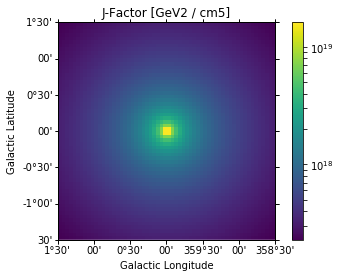

In [6]:
jfact_map = WcsNDMap(geom=geom, data=jfact.value, unit=jfact.unit)
fig, ax, im = jfact_map.plot(cmap='viridis', norm=LogNorm(), add_cbar=True)
plt.title('J-Factor [{}]'.format(jfact_map.unit))
plt.show()

In [7]:
fluxes = PrimaryFlux(mDM='1 TeV', channel='b')

In [8]:
flux = compute_dm_flux(
    jfact=jfact,
    prim_flux=fluxes, 
    x_section='1e-26 cm3s-1', 
    energy_range=[0.1, 10] * u.TeV)

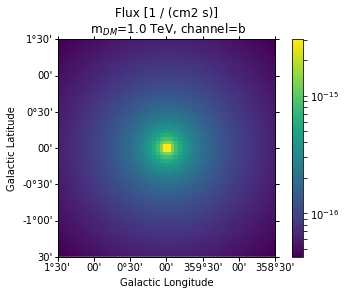

In [11]:
flux_map = WcsNDMap(geom=geom, data=flux.value, unit=flux.unit)

fig, ax, im = flux_map.plot(cmap='viridis', norm=LogNorm(), add_cbar=True)
plt.title(
    'Flux [{}]\n m$_{{DM}}$={}, channel={}'.format(
    flux_map.unit, 
    fluxes.mDM.to('TeV'),
    fluxes.channel)
);

So this is the shape of the signal we hope to see in the reisduals of the data.

### Selecting Observations

The galactic center survey contains 1670 observations. Within its first year of operation, approximately the first 300 of these observations will be complete which we choose here. 

Make sure the \$CTADATA_DM path (or \$CTADATA path) is set up in your computer. If it is not, go to your bash profile and add one of these lines: 
    
    export CTADATA=/Users/...../DC1/1dc
    export CTADATA_DM=/Users/...../DC1/1dc_dmx10

where the dots are replaced with the relevant path for your computer. 

In [2]:
data_store = DataStore.from_dir('$CTADATA_DM/index/gc')

In [3]:
obs_id = list(range(310000, 310001)) #select observations between 310000 and 311670
obs_list = data_store.obs_list(obs_id)

### Define the target region

For this analysis, the galactic center is the target region. Also, define an ON region which will be used for the exclusion mask to occult the bright source in the galactic center. Here we use 0.3 degrees, the proposed optimal size for Array E. 

In [4]:
target_position = SkyCoord(0, 0, unit='deg', frame='galactic') 

on_radius = 0.3* u.deg
on_region = CircleSkyRegion(center=target_position, radius=on_radius)

In [5]:
energy_axis = MapAxis.from_bounds(1,100,6,name='energy',unit='TeV',interp='log')

geom3d = WcsGeom.create(binsz=0.02, skydir=target_position, width=10.0, coordsys='GAL',
                       axes=[energy_axis])

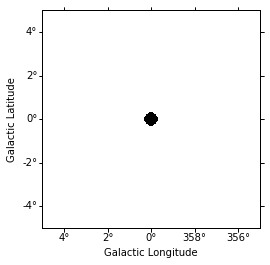

In [6]:
exclusion_mask = geom3d.to_image().region_mask([on_region], inside=False)
exclusion_mask = WcsNDMap(geom3d.to_image(), exclusion_mask)
exclusion_mask.plot();

This exclusion mask is 2D, but the adaptive ring background estimator requires a 3D exclusion mask to run, so below we can make our own 3D exclusion mask until a gammapy function is created to make 3D masks. 

In [7]:
ref_image = WcsMap.from_geom(geom3d)
ref_image.data = 1 - ref_image.data 

for e in range(0,6):
    for i in range(0,500):
        i_p = i-250
        for j in range(0,500):
            j_p = j-250
            if i_p**2 + j_p**2 <= 15**2:
                ref_image.data[e][i][j]=0

### Compling Observations

This step takes the longest time to run (depending on how many observations are selected), it took about 30 minutes for 500 observations. It outputs 3 skymap cubes (2 spatial axes and 1 energy axis):

- 'Counts': Total number of events detected per pixel, stack of all observations
- 'Exposure'
- 'Background': A model skymap of the background emission

The background image is modelled using the Adaptive Ring method, with values r_in = 0.6, r_out_max = 3, and width = 0.2 chosen for the galactic center. The Adaptive Ring method uses an algorithm to find a ring of fixed width between the r_in (inner radius) and r_out_max (maximum outer radius) values that produces the smoothest background. Here we use the defualt fixed width algorithm, but this parameter can be changed by adding the arguement 'method = 'fixed_r_in''. This method works the best for the galactic center where there is an abundance of sources. 

In [10]:
%%time
#Runs a lot faster (depending on how many energy slices)
image_estimator = MapMaker(
    geom=geom3d,
    offset_max=3 * u.deg,
    exclusion_mask=exclusion_mask,
    #optional: cutout at this stage
)
cubes = image_estimator.run(obs_list)

CPU times: user 2.67 s, sys: 712 ms, total: 3.38 s
Wall time: 3.66 s


In [11]:
images={
    'counts': cubes['counts'],
    'exposure_on': cubes['exposure'],
    'exclusion': ref_image, #see above for problem with exclusion mask
}

In [12]:
bkg_estimator = AdaptiveRingBackgroundEstimator(
    r_in=0.6 * u.deg,
    r_out_max=3 * u.deg,
    width=0.2 * u.deg,
)

results = bkg_estimator.run(images)

### Showing Images 

Here we show some plots in order to help you choose an appropriate number of observations and get a sense of what each image looks like. To plot data cubes we use the plot_interactive function.

In [13]:
results['background'].plot_interactive()

A Jupyter Widget

Although the interactive plots are great, for the rest of the analysis we will use 2D images. These cubes can be compressed to 2 dimensions by summing all the events over the energy axis.

Rather than summing over the axis for exposure, we pull one moment of the exposure cube at 1 TeV. 

In [210]:
counts_image = cubes['counts'].sum_over_axes()
bkg_image = cubes['background'].sum_over_axes()
adpbkg_image = results['background'].sum_over_axes()

#expo_image = cubes['exposure'].sum_over_axes() #why can't we use this
expo_image = cubes['exposure'].get_image_by_coord({'energy':'1 TeV'})

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x184cb1a1d0>)

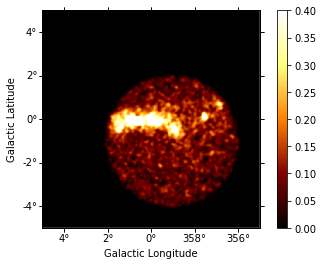

In [179]:
counts_image.smooth(radius=6).plot(add_cbar='True', vmax=0.4)

### Saving Images 

In order to use Sherpa for image fitting, you should save the counts, exposure, and background maps. Also, for Sherpa we will need a 2D image of the psf. It can't be saved like the maps since the psf has no sky coordinates. The fits files will be saved in the same directory as this notebook.

In [209]:
counts_image.write('counts.fits', overwrite=True)
expo_image.write('expo.fits', overwrite=True)
bkg_image.write('bkg.fits', overwrite=True)

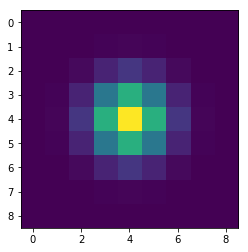

In [184]:
#how to compute psf kernal
kernel = Gaussian2DKernel(1, mode='oversample')
plt.imshow(kernel);

In [189]:
fits.writeto('psf.fits', kernel.array, overwrite=True)

### Image Fitting With Sherpa

Now that the four files are saved, load them into Sherpa, Chandra's software, for image fitting. You can pick the statistic and the method. Here, "cash" is used since it works best for images with few counts. Both the "simplex" and "moncar" methods work, but note that "moncar" is better for global fits and both methods can be used to ensure the best fit is found. 


Sometimes, if you've been running sherpa for a while, you will need to restart the kernel because the fits start to be corrupted by previous fits. Note that since the skymaps are saved you won't need to re-run the first half of the code to generate those skymaps. 

In [3]:
# Read the fits file to load them in a sherpa model
hdr = fits.getheader("counts.fits")
wcs = WCS(hdr)

sh.set_stat("cash")
sh.set_method("simplex") #or moncar
sh.load_image("counts.fits")
sh.set_coord("logical")

sh.load_table_model("expo", "expo.fits")
sh.load_table_model("bkg", "bkg.fits")
sh.load_psf("psf", "psf.fits")

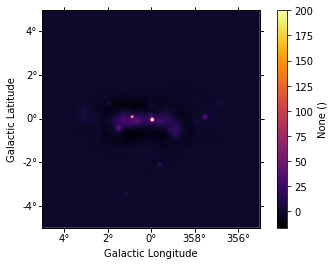

In [6]:
sh.set_full_model(bkg)
bkg.ampl = 1
sh.freeze(bkg)

data = sh.get_data_image().y -  sh.get_model_image().y
resid = SkyImage(data=data, wcs=wcs)

resid_table = []  # Keep residual images in a list to show them later
resid_smo6 = resid.smooth(radius = 3)
resid_smo6.plot(vmax=200, add_cbar=True, cmap='inferno') #add a vmin=0 statment here in each plot if you don't want neg values
resid_table.append(resid_smo6)

### Find and Fit the Brightest Source

In order to get the flattest residual image, the first step is fitting and subtracting the brightest point source. Sherpa works by taking user input on the most likely values then moving around the parameter space to find the best values. For the first fit, we need to give some reasonable values for the exposure amplitude and full-width half-max of the brightest source. We want to use the exposure map we've generated to find a general exposure value. Then below we will input the reciprocal that Sherpa will use to negate the effects of exposure. 

6.96e+09


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x1856e54c88>)

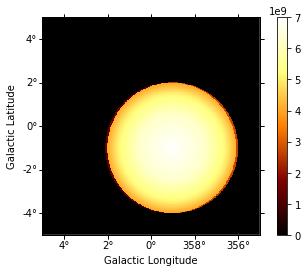

In [218]:
expo_max = expo_image.data.max()
print("{:.2e}".format(expo_max)) #to print in scientific notation

expo_image.plot(add_cbar='True', vmax=7e9) #input the expo_max value here as vmax

Now we will perform the first fit with Sherpa. We start by setting a model that includes the background and a psf-normalized and exposure-normalized gaussian point source. 

You should input the reciprocal of the general exposure value and the pixel size of the fwhm of the source. The fwhm is the area that includes 50% of the gaussian source, so for a point source we can say its a few pixels wide. 

In [7]:
maxcoord = resid_smo6.lookup_max()
maxpix = resid_smo6.wcs_skycoord_to_pixel(maxcoord[0])
sh.set_full_model(bkg + psf(sh.gauss2d.g0) * expo) # creates g0 as a gauss2d instance

g0.xpos = maxpix[0]
g0.ypos = maxpix[1]
sh.freeze(g0.xpos, g0.ypos) # fix the position in the initial fitting step

expo.ampl = (1/9.5)*1e-11 # fix exposure amplitude so that typical exposure is of order unity
sh.freeze(expo)
sh.thaw(g0.fwhm, g0.ampl) # in case frozen in a previous iteration

g0.fwhm = 4 # give some reasonable initial values (for a point source, a handful of pixels)
g0.ampl = maxcoord[1]
sh.fit() # Performs the fit; this takes a little time.

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = -2.3956e+06
Final fit statistic   = -2.40246e+06 at function evaluation 202
Data points           = 250000
Degrees of freedom    = 249998
Change in statistic   = 6861.49
   g0.fwhm        4.92701     
   g0.ampl        748.39      


Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = -2.40246e+06
Final fit statistic   = -2.4101e+06 at function evaluation 545
Data points           = 250000
Degrees of freedom    = 249996
Change in statistic   = 7642.02
   g0.fwhm        2.48533     
   g0.xpos        253.208     
   g0.ypos        249.223     
   g0.ampl        2647.61     


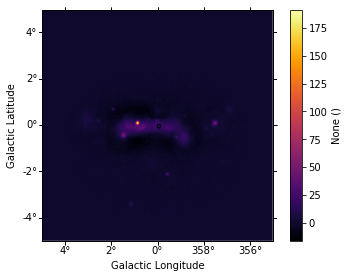

In [8]:
sh.thaw(g0.xpos, g0.ypos)
sh.fit()
sh.freeze(g0)

data = sh.get_data_image().y -  sh.get_model_image().y
resid = SkyImage(data=data, wcs=wcs)

resid_smo6 = resid.smooth(radius = 3)
resid_smo6.show(add_cbar=True, cmap='inferno')
resid_table.append(resid_smo6)

### Fit additional sources 

First, we fit an ellipse to mask the dense gas clouds in the galactic plane. You could also fit the second point source first, but I find the fit works better in this order.

Be careful with the input for position and radius! Depending on the image size, you should check the size of the image in pixels for appropriate values.

In [9]:
sh.set_full_model(bkg + psf(g0+sh.beta2d.b1) * expo)
sh.freeze(g0)

sh.thaw(b1.xpos, b1.ypos, b1.r0, b1.ellip, b1.ampl)
b1.xpos = 250 #be careful here with your pixel values! I would put the center of the image
b1.ypos = 250
b1.r0 = 200 #give a large radius, so it fits a very thin ellipse
b1.ellip = 0.8
b1.ampl = 30
sh.fit()

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = -2.0517e+06
Final fit statistic   = -2.46144e+06 at function evaluation 853
Data points           = 250000
Degrees of freedom    = 249994
Change in statistic   = 409744
   b1.r0          184.975     
   b1.xpos        222.783     
   b1.ypos        248.495     
   b1.ellip       0.809633    
   b1.ampl        38.2534     
   b1.alpha       10          


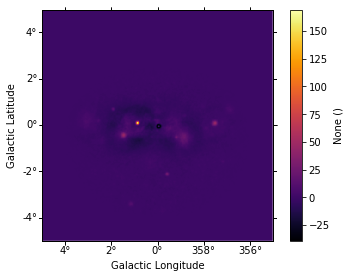

In [10]:
data = sh.get_data_image().y -  sh.get_model_image().y
resid = SkyImage(data=data, wcs=wcs)

resid_smo6 = resid.smooth(radius = 3)
resid_smo6.show(add_cbar=True, cmap='inferno')
resid_table.append(resid_smo6)

Next, with the flattened image we fit the second point source.

In [11]:
maxcoord = resid_smo6.lookup_max()
maxpix = resid_smo6.wcs_skycoord_to_pixel(maxcoord[0])

sh.set_full_model(bkg + psf(g0+sh.beta2d.b1+sh.gauss2d.g1) * expo)
sh.freeze(g0, b1)

g1.xpos = maxpix[0]
g1.ypos = maxpix[1]
sh.freeze(g1.xpos, g1.ypos)

sh.thaw(g1.fwhm, g1.ampl)
g1.fwhm = 3 
g1.ampl = 150
sh.fit()

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = -2.46558e+06
Final fit statistic   = -2.46807e+06 at function evaluation 210
Data points           = 250000
Degrees of freedom    = 249998
Change in statistic   = 2499.18
   g1.fwhm        2.85717     
   g1.ampl        571.03      


Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = -2.46807e+06
Final fit statistic   = -2.47057e+06 at function evaluation 2078
Data points           = 250000
Degrees of freedom    = 249996
Change in statistic   = 2495.55
   g1.fwhm        0.642093    
   g1.xpos        207.436     
   g1.ypos        256.374     
   g1.ampl        29538.8     


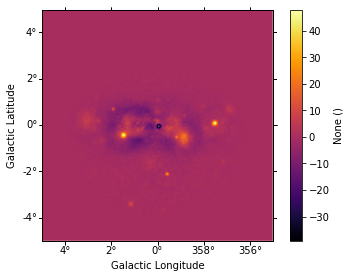

In [12]:
sh.thaw(g1.xpos, g1.ypos)
sh.fit()
sh.freeze(g1)

data = sh.get_data_image().y -  sh.get_model_image().y
resid = SkyImage(data=data, wcs=wcs)

resid_smo6 = resid.smooth(radius = 3)
resid_smo6.show(add_cbar=True, cmap='inferno')
resid_table.append(resid_smo6)

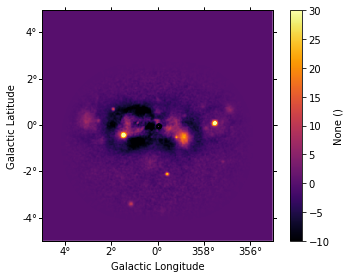

In [92]:
data = sh.get_data_image().y -  sh.get_model_image().y
resid = SkyImage(data=data, wcs=wcs)

resid_smo6 = resid.smooth(radius = 3)
resid_smo6.show(vmin=-10, vmax=30, add_cbar=True, cmap='inferno')
resid_table.append(resid_smo6)

Be careful with negative values in the residual map. If you have negative values, it is better to add a scalar value to all of the data so the gradients are preserved instead of just ignoring all the data less than 0. This can be done by finding the minimum value in the data and adding the absolute value to the entire array.

Now we just save the residuals and we are finished!

In [13]:
sh.save_resid('resid_dmx10_obs300_10deg.fits', clobber=True)

### Excercises and Future Work

Future Work for me or Excersies for the reader:
- subtracting an image of the dense gas at the galactic center instead of a beta source
- fixing the point source subtraction in Sherpa for the central point source so it is not oversubtracted

### Bonus: Comparing DM and DMx10 Datasets

We can compare the two datasets released by the CTA to see what the signal looks like. The first dataset as some dark matter, and the second dataset is identical in every aspect but the dark matter signal is amplified by 10. 

In [220]:
counts = WcsNDMap.read("dm_signal/counts_obs300_10deg.fits")
counts_dmx10 = WcsNDMap.read("dm_signal/counts_dmx10_obs300_10deg.fits")

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x1846bf0d30>)

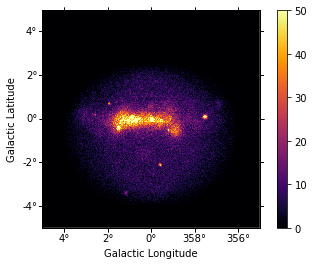

In [221]:
counts.plot(vmax=50, add_cbar=True, cmap='inferno')

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x1845433588>)

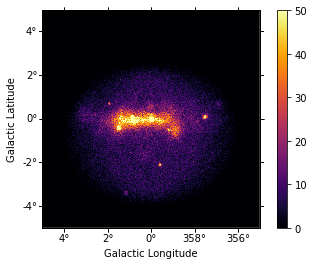

In [222]:
counts_dmx10.plot(vmax=50, add_cbar=True, cmap='inferno')

In [224]:
dm_diff = counts_dmx10.data - counts.data

In [225]:
dm_diff.max()

104.0

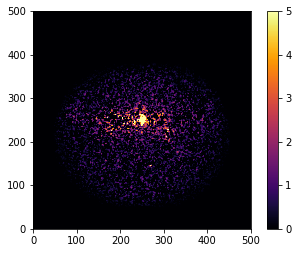

In [226]:
plt.imshow(dm_diff, cmap='inferno', vmin=0, vmax=5, interpolation = 'gaussian', origin='lower')
plt.colorbar()

In [208]:
fits.writeto('dm_signal_obs300_10deg.fits', dm_diff, overwrite=True)

Now that we know how to isolate the dark matter signal, lets observe how the number of events grows over time. 

In [60]:
c100 = WcsNDMap.read("dm_signal/counts_obs100.fits")
c100_dmx10 = WcsNDMap.read("dm_signal/counts_dmx10_obs100.fits")

c200 = WcsNDMap.read("dm_signal/counts_obs200.fits")
c200_dmx10 = WcsNDMap.read("dm_signal/counts_dmx10_obs200.fits")

c300 = WcsNDMap.read("dm_signal/counts_obs300_10deg.fits")
c300_dmx10 = WcsNDMap.read("dm_signal/counts_dmx10_obs300_10deg.fits")

c400 = WcsNDMap.read("dm_signal/counts_obs400.fits")
c400_dmx10 = WcsNDMap.read("dm_signal/counts_dmx10_obs400.fits")

c500 = WcsNDMap.read("dm_signal/counts_obs500.fits")
c500_dmx10 = WcsNDMap.read("dm_signal/counts_dmx10_obs500.fits")

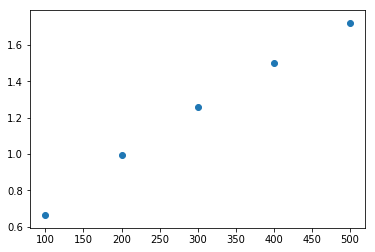

In [77]:
dm_100 = (c100_dmx10.data - c100.data)**2 / np.sqrt(c100.data + 1) #chi squared (sum of this per pixel thing)
dm_200 = (c200_dmx10.data - c200.data)**2 / np.sqrt(c200.data + 1)
dm_300 = (c300_dmx10.data - c300.data)**2 / np.sqrt(c300.data + 1)
dm_400 = (c400_dmx10.data - c400.data)**2 / np.sqrt(c400.data + 1)
dm_500 = (c500_dmx10.data - c500.data)**2 / np.sqrt(c500.data + 1)

dm_arrays = [dm_100, dm_200, dm_300, dm_400, dm_500]
dm_events = []
dm_error = []
for i in dm_arrays: 
    #i = np.sqrt(i)
    num_events = np.sum(i) / (500*500 - 2) #dividing by the degrees of freedom then subtracting by 1 for math and 1 for normalization 
    dm_events.append(num_events)
    #error = np.sqrt(num_events)
    
obs_num = [100, 200, 300, 400, 500]

fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(obs_num, dm_events)
#ax.set_yscale('log')
#plt.errorbar()
plt.show()

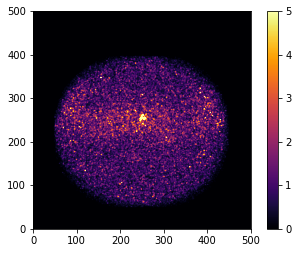

In [75]:
plt.imshow(dm_500, cmap='inferno', vmin=0, vmax=5, interpolation = 'gaussian', origin='lower')
plt.colorbar()

### Bonus: Reprojecting Skymaps

A useful skill (especially if you can figure out how to use a model image). Be careful when normalizing the data, its better not to create a new variable but to copy over the exisiting skymap so the shape and geometery are preserved (instead of just defining a new array).

To run the following cells, change them from Raw NBConvert to Code.